In [1]:
import numpy as np
import glob2
from PIL import Image
from sklearn.model_selection import train_test_split
from sklearn.metrics import accuracy_score
from sklearn.svm import SVC
import logging
import random
from numba import cuda

In [115]:
# logging.basicConfig(filename='./log.log',level=10, filemode = 'w', force=True, format='%(asctime)s   %(funcName)s - %(levelname)s:%(message)s')

# Read data

In [2]:
def read_data(link_cat, link_dog, n_samples, image_size = (400, 400), random_state = 42):
    list_cat = glob2.glob(link_cat)
    list_dog = glob2.glob(link_dog)
    cat_images = []
    cat_labels = []
    for i in range(n_samples):
        if 'jpg' in list_cat[i]:
            img = Image.open(list_cat[i]).convert('RGB')
            img = img.resize(image_size, Image.LANCZOS)
            if len(np.array(img).shape) == 3:
                cat_images.append(np.array(img))
                cat_labels.append(1)
    dog_images = []
    dog_labels = []
    for i in range(n_samples):
        if 'jpg' in list_dog[i]:
            img = Image.open(list_dog[i]).convert('RGB')
            img = img.resize(image_size, Image.LANCZOS)
            if len(np.array(img).shape) == 3:
                dog_images.append(np.array(img))
                dog_labels.append(-1)
    for index in range(len(cat_images)):
        if cat_images[index].shape[2] != 3:
            print(index, cat_images[index].shape[2])
    for index in range(len(dog_images)):
        if dog_images[index].shape[2] != 3:
            print(index, dog_images[index].shape[2])  
    cat_images = np.array(cat_images)
    cat_labels = np.array(cat_labels)
    dog_images = np.array(dog_images)
    dog_labels = np.array(dog_labels)
    
    x_cat_train, x_cat_test, y_cat_train, y_cat_test = train_test_split(cat_images, cat_labels, test_size=0.3, random_state = random_state)
    x_dog_train, x_dog_test, y_dog_train, y_dog_test = train_test_split(dog_images, dog_labels, test_size=0.3, random_state = random_state)
    X_train = np.concatenate((x_cat_train, x_dog_train), axis = 0)
    y_train = np.concatenate((y_cat_train, y_dog_train), axis = 0)
    X_test = np.concatenate((x_cat_test, x_dog_test), axis = 0)
    y_test = np.concatenate((y_cat_test, y_dog_test), axis = 0)

    s1 = np.arange(X_train.shape[0])
    random.Random(0).shuffle(s1)
    X_train = X_train.take(s1, axis = 0)
    y_train = y_train.take(s1, axis = 0)
    s2  = np.arange(X_test.shape[0])
    random.Random(5).shuffle(s2)
    X_test = X_test.take(s2, axis = 0)
    y_test = y_test.take(s2, axis = 0)
    
    return X_train, y_train, X_test, y_test

# SVM

In [103]:
class SVM_NEW:
    def __init__(self, gamma = -1, kernel = 'rbf', C = 1.0, eps = 1e-3):
        self.C = C
        self.eps = eps
        self.gamma = gamma
        self.tau = 1e-12
        self.kernel = kernel
        self.gamma = gamma
    
    def Kernel(self, x1, x2):
        if self.kernel == 'rbf':
            return self.rbf(x1, x2)
        if self.kernel == 'linear':
            return self.linear(x1, x2)

    def get_Q(self, X, i, j):
        if self.Q[i, j] == None:
            self.Q[i][j] = self.y[i] * self.y[j] * self.get_K(X, i, j)
            self.Q[j][i] = self.Q[i][j]
        return self.Q[i][j]
    
    def get_K(self, X, i, j):
        if self.K[i, j] == None:
            self.K[i][j] = self.Kernel(X[i], X[j])
            self.K[j][i] = self.K[i][j]
        return self.K[i][j]
    
    def linear(self, x1, x2):
        x1_temp = x1.astype(np.float64)
        x2_temp = x2.astype(np.float64)
        return x1_temp.dot(x2_temp)
    
    def rbf(self, x1, x2):
        x1_temp = x1.astype(np.float64)
        x2_temp = x2.astype(np.float64)
        return np.exp(-self.gamma * (x1_temp.dot(x1_temp) + x2_temp.dot(x2_temp) - 2.0 * x1_temp.dot(x2_temp)))
        
    def select_B(self, X):
        i = -1
        G_max = -np.inf
        G_min = np.inf
        for t in range(self.l):
            if (self.y[t] == 1 and self.alphas[t] <self.C) or \
            (self.y[t] == -1 and self.alphas[t] > 0):
                if -self.y[t] * self.G[t] >= G_max:
                    i = t
                    G_max = -self.y[t] * self.G[t]
        j = -1
        obj_min = np.inf
        for t in range(self.l):
            if (self.y[t]==1 and self.alphas[t]>0) or \
                (self.y[t] == -1 and self.alphas[t] < self.C):
                    b = G_max + self.y[t] * self.G[t]
                    if -self.y[t]*self.G[t] <= G_min:
                        G_min = -self.y[t] * self.G[t]
                    if b>0:
                        a = self.get_Q(X, i, i) + self.get_Q(X, t, t) - 2.0*self.y[i]*self.y[t]*self.get_Q(X, i, t)
                        if a<=0:
                            a = self.tau
                        if -(b*b)/a <= obj_min:
                            j = t
                            obj_min = -(b*b)/a
        if G_max - G_min < self.eps:
            return -1, -1
        return i, j

    def predict(self, X):
        pred = []
        for x in X:
            sum = 0.0
            for i in range(self.l):
                sum += self.y[i] * self.alphas[i] * self.Kernel(self.X[i], x)
            sum -= self.b
            pred.append(np.sign(sum))
        return pred

    def get_b(self):
        sum = 0.0
        count = 0
        for i in range(self.l):
            if 0 < self.alphas[i] < self.C:
                count += 1
                sum += self.y[i] * self.G[i]
        if count > 0:
            self.b = sum/count
            return
        max = -np.inf
        min = np.inf
        for i in range(self.l):
            if (self.alphas[i] == 0 and self.y[i] == -1) or \
                (self.alphas[i] == self.C and self.y[i] == 1):
                    if max < self.y[i] * self.G[i]:
                        max = self.y[i] * self.G[i]
            if (self.alphas[i] == 0 and self.y[i] == 1) or \
                (self.alphas[i] == self.C and self.y[i] == -1):
                    if min > self.y[i] *self.G[i]:
                        min = self.y[i] * self.G[i]
        self.b = (min+max) / 2

    def fit(self, X, y):
        self.y = y
        self.X = X
        self.l = len(y)
        if self.gamma == -1:
            self.gamma = 1/(X.shape[1]*X.var())
        self.active_size= self.l
        self.alphas = np.zeros(self.l)
        self.n_iter = 0

        self.K = np.array([[None for _ in range(self.l)] for _ in range(self.l)])
        self.Q = np.array([[None for _ in range(self.l)] for _ in range(self.l)])
        self.G = np.array([-1.0 for _ in range(self.l)])
        while True:
            i, j = self.select_B(X)
            if j == -1:
                break
            self.n_iter += 1
            alphai = self.alphas[i]
            alphaj = self.alphas[j]
            if y[i] != y[j]:
                quad_coef = self.get_Q(X, i, i) + self.get_Q(X, j, j) + 2*self.get_Q(X, i, j)
                if quad_coef <= 0:
                    quad_coef = self.tau
                delta = (-self.G[i] - self.G[j])/quad_coef
                diff = alphai - alphaj
                self.alphas[i] += delta
                self.alphas[j] += delta
                if diff > 0:
                    if self.alphas[j]<0:
                        self.alphas[j] = 0
                        self.alphas[i] = diff
                    if self.alphas[i]>self.C:
                        self.alphas[i] = self.C
                        self.alphas[j] = self.C - diff
                else:
                    if self.alphas[i]<0:
                        self.alphas[i] = 0
                        self.alphas[j] = -diff
                    if self.alphas[j]>self.C:
                        self.alphas[j] = self.C
                        self.alphas[i] = self.C + diff
            else:
                quad_coef = self.get_Q(X, i, i) + self.get_Q(X,j,j) - 2*self.get_Q(X,i,j)
                if quad_coef <=0:
                    quad_coef = self.tau
                delta = (self.G[i]-self.G[j])/quad_coef
                sum = alphai + alphaj
                self.alphas[i] -= delta
                self.alphas[j] += delta
                if sum>self.C:
                    if self.alphas[i]>self.C:
                        self.alphas[i] = self.C
                        self.alphas[j] = sum-self.C
                    if self.alphas[j]>self.C:
                        self.alphas[j] = self.C
                        self.alphas[i] = sum-self.C
                else:
                    if self.alphas[j]<0:
                        self.alphas[j] = 0
                        self.alphas[i] = sum
                    if self.alphas[i]<0:
                        self.alphas[i] = 0
                        self.alphas[j] = sum
            delta_ai = self.alphas[i] - alphai
            delta_aj = self.alphas[j] - alphaj
            
            for t in range(self.l):
                self.G[t] += self.get_Q(X, i, t) * delta_ai + self.get_Q(X, j, t) *delta_aj
        self.get_b()

In [100]:
link_cat = './PetImages/Cat/**'
link_dog = './PetImages/Dog/**'
X_train, y_train, X_test, y_test = read_data(link_cat, link_dog, n_samples = 100, random_state = 0)
x_train = np.array([x.flatten() for x in X_train])
x_test = np.array([x.flatten() for x in X_test])
print(x_train.shape)
print(x_test.shape)

(140, 480000)
(60, 480000)


In [104]:
svm = SVM_NEW()
svm.fit(x_train, y_train)
pred = svm.predict(x_test)
accuracy_score(pred, y_test)

0.5833333333333334

In [105]:
y_train_sklearn = np.array([str(y) for y in y_train])
y_test_sklearn = np.array([str(y) for y in y_test])
svc = SVC(shrinking = False)
svc.fit(x_train, y_train_sklearn)
pred = svc.predict(x_test)
accuracy_score(pred, y_test_sklearn)

0.5833333333333334

In [119]:
class SVM_OLD:
  def __init__(self, C=1.0, gamma=0.1, tol=1e-3, max_iter=1200):
    self.C = C
    self.gamma = gamma
    self.tol = tol
    self.max_iter = max_iter
    self.n_iter = 0
    self.eps = 1e-5

  def rbf(self, x1, x2):
    return np.exp(-self.gamma * (np.linalg.norm(x1 - x2) **2 ))
  
  def output(self, x, X, y, n_samples):
    return np.sum([self.alphas[i] * y[i] * self.rbf(X[i], x) for i in range(n_samples)]) - self.b

  def get_error(self, i, X, y):
    if self.non_bound[i]:
      return self.errors[i]
    else:
      op = self.output(X[i], X, y, self.n_samples) - y[i]
      self.errors[i] = op
      return op  

  def predict(self, X):
    pred = []
    for x in X:
      pred.append(np.sign(self.output(x, self.support_vectors, self.support_vector_labels, self.n_vector)))
    return pred
    
  def compute_L_H(self):
    if self.y1 != self.y2:
      L = max(0, self.alpha2 - self.alpha1)
      H = min(self.C, self.C + self.alpha2 - self.alpha1)
    else:
      L = max(0, self.alpha2 + self.alpha1 - self.C)
      H = min(self.C, self.alpha2 + self.alpha1)
    return L, H
  
  def compute_threshold(self, alpha1_new, alpha2_new, k11, k12, k22):
    b1 = self.E1 + self.y1 * (alpha1_new - self.alpha1) * k11 + \
        self.y2 * (alpha2_new - self.alpha2) * k12 + self.b
    b2 = self.E2 + self.y1 * (alpha1_new - self.alpha1) * k12 + \
        self.y2 * (alpha2_new - self.alpha2) * k22 + self.b

    if 0 < alpha1_new and alpha1_new < self.C:
      return b1
    if 0 < alpha2_new and alpha2_new < self.C:
      return b2
    return (b1 + b2)/2.0
    
  def update_error_cache(self, alpha1_new, alpha2_new, old_b, X):
    delta1 = self.y1 * (alpha1_new - self.alpha1)
    delta2 = self.y2 * (alpha2_new - self.alpha2)
    for i in self.non_bound_idx:
      self.errors[i] += delta1 * self.rbf(self.x1, X[i]) + \
                        delta2 * self.rbf(self.x2, X[i]) + \
                        old_b - self.b
                        
  def update_error2(self, alpha1_new, alpha2_new, old_b, X):
    delta1 = self.y1 * (alpha1_new - self.alpha1)
    delta2 = self.y2 * (alpha2_new - self.alpha2)
    for i in range(self.n_samples):
      self.errors2[i] += delta1 * self.rbf(self.x1, X[i]) + \
                        delta2 * self.rbf(self.x2, X[i]) + \
                        old_b - self.b
    
  def update_non_bound(self, i1, i2):
    if 0 < self.alphas[i1] and self.alphas[i1] < self.C:
      self.non_bound[i1] = True
      if i1 not in self.non_bound_idx:
        self.non_bound_idx.append(i1)
    else:
      self.non_bound[i1] = False
      if i1 in self.non_bound_idx:
        self.non_bound_idx.remove(i1)
      
    if 0 < self.alphas[i2] and self.alphas[i2] < self.C:
      self.non_bound[i2] = True
      if i2 not in self.non_bound_idx:
        self.non_bound_idx.append(i2)
    else:
      self.non_bound[i2] = False
      if i2 in self.non_bound_idx:
        self.non_bound_idx.remove(i2)

    
  def get_alpha2(self, L, H, k11, k12, k22, s):
    eta = k11 + k22 - 2 * k12
    if eta > 0:
      alpha2_new = self.alpha2 + self.y2 * (self.E1-self.E2)/eta
      alpha2_new = min(H, max(L, alpha2_new))
    else:
      # print("ETA < 0")
      # logging.error("ETA <= 0")
      f1 = self.y1*(self.E1 + self.b) - self.alpha1*k11 - s*self.alpha2*k12
      f2 = self.y2*(self.E2 + self.b) - s*self.alpha1*k12 - self.alpha2*k22
      L1 = self.alpha1 + s*(self.alpha2-L)
      H1 = self.alpha1 + s*(self.alpha2-H)
      Lobj = L1*f1 + L*f2 + 0.5*(L1**2)*k11 + 0.5*(L**2)*k22 + s*L*L1*k12
      Hobj = H1*f1 + H*f2 + 0.5*(H1**2)*k11 + 0.5*(H**2)*k22 + s*H*H1*k12
      if Lobj < Hobj - self.eps:
        alpha2_new = L
      elif Lobj > Hobj + self.eps:
        alpha2_new = H
      else:
        alpha2_new = self.alpha2
    return alpha2_new
    
  def take_step(self, i1, i2, X, y):
    if i1 == i2:
      return 0
    self.y2 = y[i2]
    self.alpha2 = self.alphas[i2]
    self.x2 = X[i2]
    self.E2 = self.get_error(i2, X, y)
    s = self.y1 * self.y2
    L, H = self.compute_L_H()
    if L==H:
      # logging.debug("L=H")
      return 0
    k11 = self.rbf(self.x1, self.x1)
    k12 = self.rbf(self.x1, self.x2)
    k22 = self.rbf(self.x2, self.x2)
    self.alphas[i2] = self.get_alpha2(L, H, k11, k12, k22, s)
    # logging.debug(f"{self.alphas[i2]-self.alpha2}\t{self.eps * (self.alphas[i2] + self.alpha2 + self.eps)}")
    if abs(self.alphas[i2] -self.alpha2) < self.eps * (self.alphas[i2] + self.alpha2 + self.eps):
      return 0
    self.alphas[i1] = self.alpha1 + s * (self.alpha2 - self.alphas[i2])
    old_b = self.b
    self.b = self.compute_threshold(self.alphas[i1], self.alphas[i2], k11, k12, k22)
    self.update_non_bound(i1, i2)
    self.update_error_cache(self.alphas[i1], self.alphas[i2], old_b, X)
    # logging.warning(f"alpha[{i1}]: {self.alphas[i1]};\talpha[{i2}]: {self.alphas[i2]}") #;\t[{L},  {H}]")
    return 1
  
  def second_choice_heuristic(self, X ,y):
    i2 = -1
    m = 0.0
    for i in self.non_bound_idx:
      step = abs(self.get_error(i, X, y) - self.E1)
      if step > m:
        m = step
        i2 = i
    return i2
  

  def examine_example(self, i1, X, y):
    self.y1 = y[i1]
    self.alpha1 = self.alphas[i1]
    self.x1 = X[i1]
    self.E1 = self.get_error(i1, X, y)
    
    r2 = self.E1 * self.y1
    if (r2 < -self.tol and self.alpha1 < self.C) or \
      (r2 > self.tol and self.alpha1 > 0):
      n_non_bound = len(self.non_bound_idx)
      mark = -1
      if (n_non_bound > 1):
        i2 = self.second_choice_heuristic(X, y)
        if i2 != -1:
          if self.take_step(i1, i2, X, y):
            return 1
          # logging.info(f"B1 Fail with {i1}, {i2}")
        mark = i2
      if n_non_bound > 0:
        rand_i = random.randrange(n_non_bound)
        for i2 in self.non_bound_idx[rand_i:] + self.non_bound_idx[:rand_i]:
          if i2 == mark:
            continue
          if self.take_step(i1, i2, X, y):
            return 1
          # logging.info(f"B2 Fail with {i1}, {i2}")
          
      rand_i = random.randrange(self.n_samples)
      all_indexes = list(range(self.n_samples))
      for i2 in all_indexes[rand_i:] + all_indexes[:rand_i]:
        if self.non_bound[i2]:
          continue
        if self.take_step(i1, i2, X, y):
          return 1
        # logging.info(f"B3 Fail with {i1}, {i2}")
    return 0

  def fit(self, X, y):
    random.seed(42)
    self.n_samples, self.n_features = X.shape
    self.errors = np.zeros(self.n_samples)
    self.alphas = np.zeros(self.n_samples)
    self.non_bound = np.array([False for _ in range(self.n_samples)])
    self.non_bound_idx = []
    self.errors2 = -1.0*y
    # logging.info(y)
    # logging.info(self.errors2)
    self.b = 0
    num_changed = 0
    examine_all = True
    self.n_iter = 0
    while num_changed > 0 or examine_all:
      self.n_iter += 1
      # logging.debug(f"N iter: {self.n_iter}")
      # logging.debug(f"examine_all: {examine_all}, numchanged: {num_changed}")
      num_changed = 0
      if examine_all:
        for i in range(self.n_samples):
          num_changed += self.examine_example(i, X, y)
      else:
        for i in range(self.n_samples):
          if 0 < self.alphas[i] < self.C:
            num_changed += self.examine_example(i, X, y)
  
      if examine_all:
        examine_all = False
      elif num_changed == 0:
        examine_all = True
        
    sv_idx = (self.alphas > 0)
    # logging.info(f"Filtering support vectors, there are {np.sum(sv_idx)} alphas")
    self.support_vectors = X[sv_idx]
    self.support_vector_labels = y[sv_idx]
    self.n_vector = np.sum(sv_idx)
    # logging.info("Done fitting")

In [120]:
class SVM_THANG:

    def __init__(self, C = 1.0):
        # C = error term
        self.C = C
        self.w = 0
        self.b = 0

    # Hinge Loss Function / Calculation
    def hingeloss(self, w, b, x, y):
        # Regularizer term
        reg = 0.5 * (w * w)

        for i in range(x.shape[0]):
            # Optimization term
            opt_term = y[i] * ((np.dot(w, x[i])) + b)

            # calculating loss
            loss = reg + self.C * max(0, 1-opt_term)
        return loss[0]

    def fit(self, X, Y, batch_size=100, learning_rate=0.001, epochs=1000):
        # The number of features in X
        number_of_features = X.shape[1]

        # The number of Samples in X
        number_of_samples = X.shape[0]

        c = self.C

        # Creating ids from 0 to number_of_samples - 1
        ids = np.arange(number_of_samples)

        # Shuffling the samples randomly
        np.random.shuffle(ids)

        # creating an array of zeros
        w = np.zeros(number_of_features)
        b = 0
        losses = []

        # Gradient Descent logic
        for i in range(epochs):
            # Calculating the Hinge Loss
            l = self.hingeloss(w, b, X, Y)

            # Appending all losses 
            losses.append(l)
            
            # Starting from 0 to the number of samples with batch_size as interval
            for batch_initial in range(0, number_of_samples, batch_size):
                gradw = 0
                gradb = 0

                for j in range(batch_initial, batch_initial+ batch_size):
                    if j < number_of_samples:
                        x = ids[j]
                        ti = Y[x] * (np.dot(w, X[x].T) + b)

                        if ti > 1:
                            gradw += 0
                            gradb += 0
                        else:
                            # Calculating the gradients

                            #w.r.t w 
                            gradw += c * Y[x] * X[x]
                            # w.r.t b
                            gradb += c * Y[x]

                # Updating weights and bias
                w = w - learning_rate * w + learning_rate * gradw
                b = b + learning_rate * gradb

        self.w = w
        self.b = b
        return self.w, self.b, losses

    def predict(self, X):
        prediction = np.dot(X, self.w) + self.b # w.x + b
        return np.sign(prediction)

# Test 

In [126]:
n_test = [20, 50, 100]
link_cat = './PetImages/Cat/**'
link_dog = './PetImages/Dog/**'
acc1 = []
acc2 = []
acc3 = []
acc4 = []
time1 = []
time2 = []
time3 = []
time4 = []
import time
for n in n_test:
    X_train, y_train, X_test, y_test = read_data(link_cat, link_dog, n, random_state = 0)
    x_train = np.array([x.flatten() for x in X_train])
    x_test = np.array([x.flatten() for x in X_test])
    gamma = 1/(x_train.shape[1]*x_train.var())
    y_train_sklearn = np.array([str(y) for y in y_train])
    y_test_sklearn = np.array([str(y) for y in y_test])
    
    print("New SVM")
    start = time.time()
    svm = SVM_NEW(C = 1.0, gamma = gamma)
    svm.fit(x_train, y_train)
    pred = svm.predict(x_test)
    end = time.time()
    time1.append(end-start)
    acc1.append(accuracy_score(pred, y_test))
    
    # print("Old SVM")
    # start = time.time()
    # svm = SVM_OLD(C = 1.0, gamma = gamma)
    # svm.fit(x_train, y_train)
    # pred = svm.predict(x_test)
    # end = time.time()
    # time2.append(end-start)
    # acc2.append(accuracy_score(pred, y_test))
    
    print("Thang SVM")
    start = time.time()
    svm = SVM_THANG(C = 1.0)
    svm.fit(x_train, y_train)
    pred = svm.predict(x_test)
    end = time.time()
    time3.append(end-start)
    acc3.append(accuracy_score(pred, y_test))
    
    print("Sklearn SVM")
    start = time.time()
    svm = SVC(kernel = 'rbf', C = 1.0, gamma = gamma, )
    svm.fit(x_train, y_train_sklearn)
    pred = svm.predict(x_test)
    end = time.time()
    time4.append(end-start)
    acc4.append(accuracy_score(pred, y_test_sklearn))

New SVM
Thang SVM


KeyboardInterrupt: 

In [125]:
np.dot(n_test, 2)

array([ 40, 100])

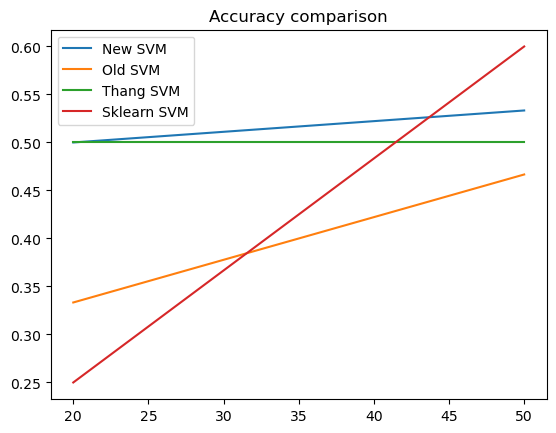

In [122]:
import matplotlib.pyplot as plt
n = np.dot(n_test, 2)
plt.plot(n, acc1, label = 'New SVM')
# plt.plot(n, acc2, label = 'Old SVM')
plt.plot(n, acc3, label = 'Thang SVM')
plt.plot(n, acc4, label = 'Sklearn SVM')
plt.ylabel("Số lượng mẫu")
plt.xlabel("Accuracy")
plt.title("Accuracy comparison")
plt.legend()
plt.show()

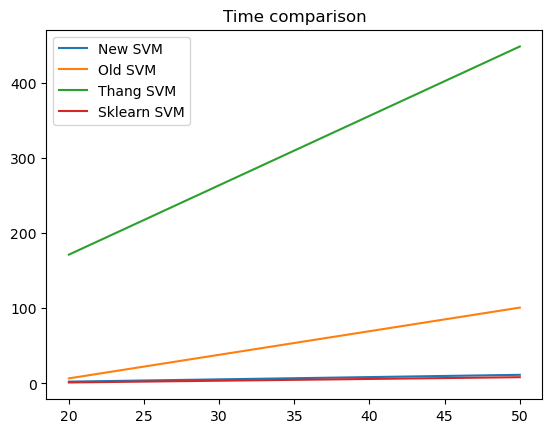

In [123]:
plt.plot(n, time1, label = 'New SVM')
# plt.plot(n, time2, label = 'Old SVM')
plt.plot(n, time3, label = 'Thang SVM')
plt.plot(n, time4, label = 'Sklearn SVM')
plt.ylabel("Số lượng mẫu")
plt.xlabel("Thời gian (s)")
plt.title("Time comparison")
plt.legend()
plt.show()